## Executive Summary

In this project, we will analyze a network dataset at an organization in the interest of discovering <b>gender</b>'s influence on how people connect. Specifically, we would like to test two hypotheses as below. 

Hypothesis 1: People are more likely to connect with their own gender <br/>
Hypothesis 2: Women have more connections than men 



### Hypothesis 1: women more likely to connect with other women and men more likely to connect with other men. 

1. The gender assortativity is 0.2699, which can be interpreted as 'The network has more edges between the same gender compared to a random network. However, the network is not strongly assortative.<br/><br/>

2. Interestingly, when computing an assortativity value for each level separately(level 1: most senior level 5: least senior), the least senior network (level 5) is strongly assortative (r = 0.48) as can be seen in Table 1 below. 

Table 1. Assortativity by level

In [403]:
assortativity_level3

,Level,Assortativity
0,1.0,-0.111111
1,2.0,-0.109137
2,3.0,0.240024
3,4.0,0.122820
4,5.0,0.476396


In order to use the level 5 assortativity instead of the network assortativity, we have to explain why the level 5 assortativity is more appropriate to prove our hypothesis. I have two conjectures (scenarios) that I would like to evaluate. 


Assumption: more senior employees have more managerial responsibilities (which can be seen as 'noise' for measuring true assortativity)

    Scenario 1. 
    Level 5 is the purest network to compute the assortativity they are not obligated to connect or communicate.  

    Scenario 2.
    Level 5 network is not the puerest network to compute the assortativity because they are also obligated to communicate with senior employees. 

To find which scenario is more plausible, we looked into the distribution of the target levels of the level 5 employees.<br/>
As can be seen in Table 2 below, their targets are heavily concentrated on level 4 and 5 which are the similar levels to them. Therefore, the level 5 assortativity could be a better metric to represent the entire network's property about gender's influence on communication. However, further research is needed to verify the story.

Table 2. Distribution of level 5 targets

In [404]:
level5.Level_y.value_counts()

4.0    750
5.0    721
3.0    333
2.0     42
1.0     13
Name: Level_y, dtype: int64

## Hypothesis 2: Women have more connections than men do. 

Hypothesis and permutation tests were performed to evalute this hypothesis in two parts (for the entire network and for the each level)

1. Entire network: There is a statistically significant difference in the number of out-degrees (women have more connections!)
2. By level: There is a statistically significant difference in the number of out-degrees for only level 5. (women have more connections!)

Please see below for the detailed outcomes. 
1. Entire network <br/>

      a) Out-degree: The number of out-degrees for men and women are as below and the difference is statistically significant based on the p-value (0.047) from a permutation test. (women have more connections!)

In [405]:
outdegree_diff

,Male,Female
# of out-degrees,7.783715,9.287671


In [406]:
p_val_permu_out2

0.0471952804719528

   b) In-degree: the number of in-degrees for men and women are as below and the difference is not significant (p-value: 0.58)


In [407]:
indegree_diff

,Male,Female
# of in-degrees,8.592875,7.835616


In [408]:
p_val_permu_in2

0.5807419258074192

2. By level <br/>
a) Out-degree: please see below for the average number of out-degrees by level and gender. Level 5 is the only level that has a statistical significance (women have more connections!)

In [409]:
mean_degree_level_table

,Level,Male,Female
0,Level:1,10.000000,NaN
1,Level:2,12.571429,5.500000
2,Level:3,11.119048,12.347826
3,Level:4,10.119048,8.934959
4,Level:5,5.617512,9.014085


In [410]:
pval_by_level_table

,Level,P-value
0,Level:1,NaN
1,Level:2,0.131013
2,Level:3,0.604524
3,Level:4,0.318692
4,Level:5,0.002616


b) In-degree <br/>
None of the levels have significant differences between men and women as can be seen below.

In [411]:
mean_degree_level_in_table

,Level,Male,Female
0,Level:1,195.000000,NaN
1,Level:2,49.714286,44.500000
2,Level:3,29.571429,23.695652
3,Level:4,7.619048,7.008130
4,Level:5,2.912442,3.098592


In [412]:
pval_by_level_t2_table

,Level,P-value
0,Level:1,NaN
1,Level:2,0.863937
2,Level:3,0.302548
3,Level:4,0.638346
4,Level:5,0.761809


## Project Details

## 1. Project Goal

In this project, a network dataset will be analyzed as to discover <b>gender</b>'s influence on how communications, information, and advice flow through an organization. 

In [413]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import igraph as ig
import networkx as nx
from scipy.stats import ttest_ind
from mlxtend.evaluate import permutation_test
import seaborn as sns
from IPython.display import SVG, display, HTML
import base64
_html_template='<img width="{}" src="data:image/svg+xml;base64,{}" >'
import statsmodels.api as sm
import itertools
from heatmap import heatmap, corrplot

def svg_to_fixed_width_html_image(svg, width="100%"):
    text = _html_template.format(width, base64.b64encode(svg))
    return HTML(text)

## 1. Descriptive Gender Analysis

I will analyze the sample data to see if there's any meaningful patterns on in-degree and out-degree connectivity by'label' between men and women. The survey participants were given nine labels (reasons) of communication to choose: Energy, Trust, Career Development, Personal Support, Decision Making, Access, Innovation, Problem Solving, and Strategy. 

In [414]:
#Load data into dataframe
nodes = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Nodes with attributes.csv')
link = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Links - Intragroup.csv')
nodes_all = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Nodes with attributes.csv')
nodes_respond = nodes_all[nodes_all['Responded']=='YES']
#Select columns of interst from node data 
nodes = nodes[['ID','Gender']]

#Out-degree statistics by Gender and Label
link_source = link.rename(columns = {'Source': "ID"})
out_degree1 = pd.merge(link_source,nodes,how='left',on = 'ID')
by_label_out_degree = out_degree1.groupby(['Gender','Label']).ID.count().reset_index()



#In-degree statistics by Gender and Label
link_source2 = link.rename(columns = {"Target":"ID"})
in_degree = pd.merge(link_source2,nodes,how='left',on = 'ID')
by_label_in_degree = in_degree.groupby(['Gender','Label']).ID.count().reset_index()

#Gender to gender in and out degree statistics 
in_degree.rename(columns = {'Gender': 'Gender_in','ID': 'Target2','Source':'Source2','Label':'Label2'},inplace=True)
out_degree1.rename(columns = {'Gender': 'Gender_out','ID': 'Source'},inplace=True)
combined = pd.concat([out_degree1,in_degree],axis=1)
combined = combined[['Source','Target','Label','Gender_out','Gender_in']]
gender_to_gender = combined.groupby(['Gender_out','Gender_in']).Source.count().reset_index()

#Normalizing the number of degrees
by_label_out_degree['Gender2'] = by_label_out_degree.Gender.map({'Female':0,'Male': 1})
by_label_out_degree['NormID'] = by_label_out_degree.apply(lambda row: row['ID']/ 219 if row['Gender2'] == 0 else row['ID']/ 393,axis=1)
by_label_in_degree['NormID'] = by_label_in_degree.apply(lambda row: row['ID']/219 if row['Gender']=='Female' else row['ID']/393, axis = 1)

## a. Number of survey participants 

,Gender,ID
0,Female,181
1,Male,295


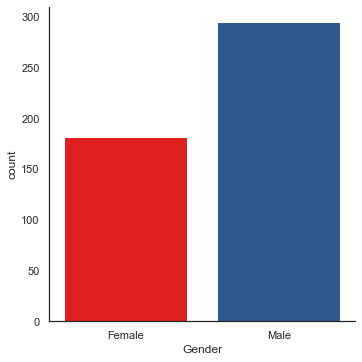

In [415]:
sns.set_theme(style='white')
g = sns.catplot(data=nodes_respond,kind='count',x='Gender',palette = sns.color_palette(['red','#2157A4']))
nodes_respond.groupby('Gender').ID.count().reset_index()

### <font color='blue'> 476 people out of 612 responded to the survey. (181 - female, 295 - male)

## b. Number of out-degrees/person and in-degrees/person by gender 

Text(0.5, 1.0, 'Number of out-degrees/person (Normalized)')

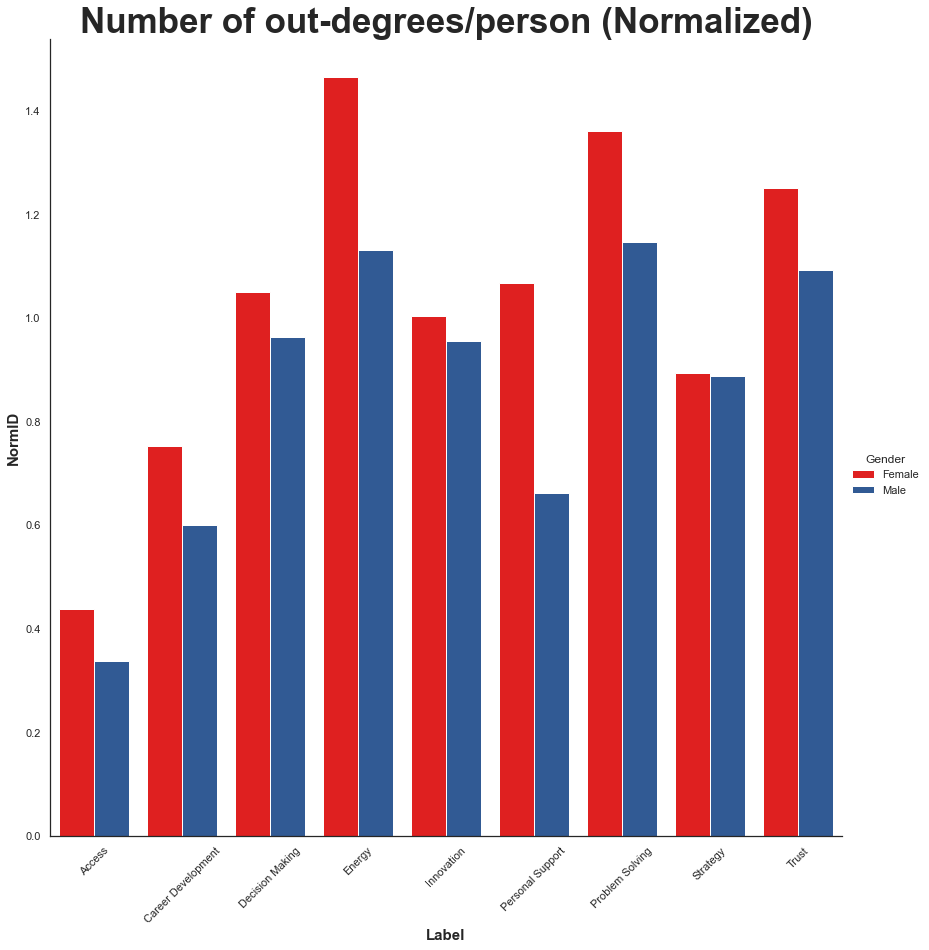

In [416]:
o = sns.catplot(data= by_label_out_degree,kind='bar',x='Label',y='NormID',hue='Gender',height = 11.7,palette = sns.color_palette(['red','#2157A4']))
o.set_xticklabels(rotation=45)
o.set_xlabels(fontsize=15,fontweight='bold')
o.set_ylabels(fontsize=15,fontweight='bold')
plt.title('Number of out-degrees/person (Normalized)',fontsize = 35,fontweight = 'bold')

### <font color='blue'> Across all of the labels (communication reasons), females have more out-degrees than males. From this data, I can construct a hypothesis that females more than men. Later, I will perform a hypothesis test to see if the hypothesis is statistically significant. 

Text(0.5, 1.0, 'Number of in-degrees/person (Normalized)')

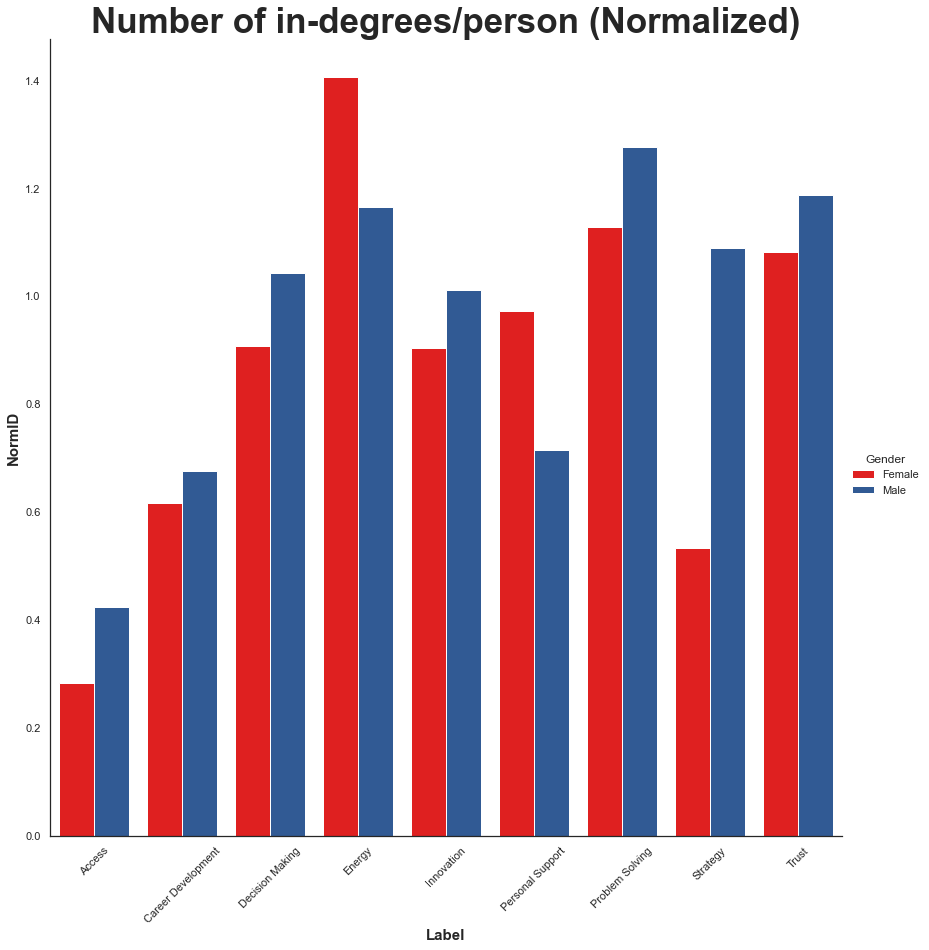

In [417]:
i = sns.catplot(data=by_label_in_degree,kind='bar',x='Label', y='NormID',hue='Gender',height = 11.7,palette = sns.color_palette(['red','#2157A4']))
i.set_xticklabels(rotation = 45)
i.set_xlabels(fontsize=15,fontweight='bold')
i.set_ylabels(fontsize=15,fontweight='bold')
plt.title('Number of in-degrees/person (Normalized)',fontsize = 35,fontweight = 'bold')

### <font color='blue'> Unlike the out-degree result above, males tend to have more in-degrees than women. However, for energy and personal support, females have more in-degrees. There's no dominant patterns in term of gender. 

In [418]:
combined

,Source,Target,Label,Gender_out,Gender_in
0,427685,428855,Energy,Female,Female
1,428309,428686,Trust,Male,Male
2,428309,428686,Career Development,Male,Male
3,428309,428686,Personal Support,Male,Male
4,428309,428686,Decision Making,Male,Male
...,...,...,...,...,...
5088,427919,428049,Access,Male,Male
5089,427919,428049,Personal Support,Male,Male
5090,427919,428049,Decision Making,Male,Male
5091,427932,427958,Trust,Male,Male


In [419]:
#Gender to gender statistics by label
label = combined['Label'].unique()
for i in range(0,len(label)):
    sector = combined[combined['Label'] == label[i]]
    sector_group = sector.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
    b= print('{0}'.format(label[i]),sector_group)

Energy   Gender_out Gender_in  Source
0     Female    Female     190
1     Female      Male     131
2       Male    Female     118
3       Male      Male     327
Trust   Gender_out Gender_in  Source
0     Female    Female     137
1     Female      Male     137
2       Male    Female     100
3       Male      Male     330
Career Development   Gender_out Gender_in  Source
0     Female    Female      81
1     Female      Male      84
2       Male    Female      54
3       Male      Male     182
Personal Support   Gender_out Gender_in  Source
0     Female    Female     154
1     Female      Male      80
2       Male    Female      59
3       Male      Male     201
Decision Making   Gender_out Gender_in  Source
0     Female    Female     114
1     Female      Male     116
2       Male    Female      85
3       Male      Male     294
Access   Gender_out Gender_in  Source
0     Female    Female      34
1     Female      Male      62
2       Male    Female      28
3       Male      Male     10

"'for i in range(0,len(label)):\n    sector = combined[combined['Label'] == label[i]]\n    sector_group = sector.groupby(['Gender_out','Gender_in']).Source.count().reset_index()\n    sector_group = sector_group.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')\n    sns.heatmap(data=sector_group)"

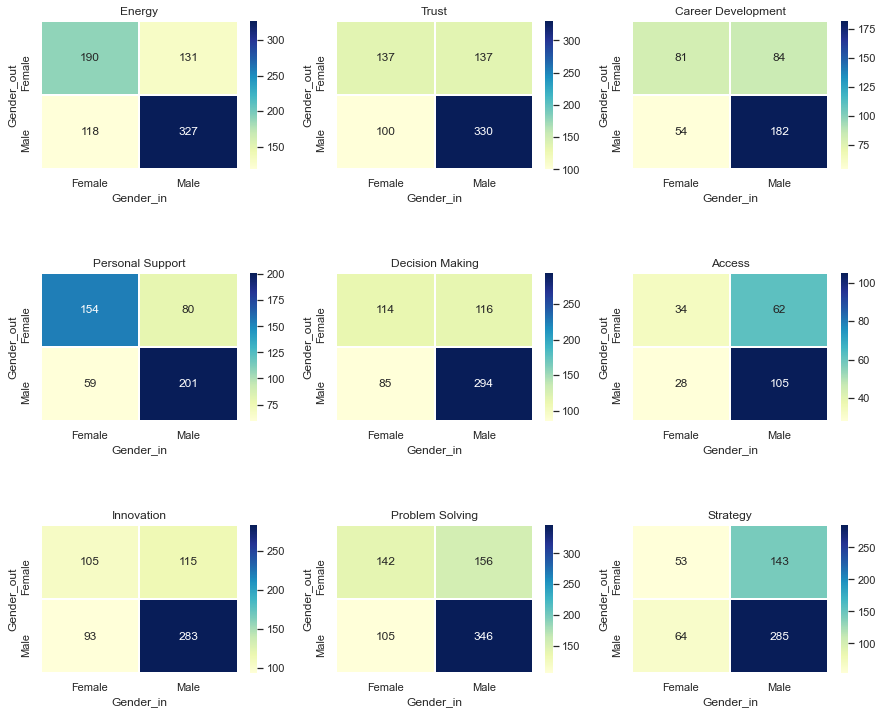

In [420]:
#Gender to gender statistics by label
label = combined['Label'].unique()
plt.figure(figsize=(15,12))

#Energy
sector_e = combined[combined['Label'] == 'Energy']
sector_group_e = sector_e.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_e = sector_group_e.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,1)
sns.heatmap(data=sector_group_e,linewidths=1,annot = True, fmt = 'd', cmap="YlGnBu")
plt.title('Energy')

#Trust
sector_t = combined[combined['Label'] == 'Trust']
sector_group_t = sector_t.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_t = sector_group_t.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,2)
sns.heatmap(data=sector_group_t,linewidths=1,annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Trust')

#Career Development
sector_c = combined[combined['Label'] == 'Career Development']
sector_group_c = sector_c.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_c = sector_group_c.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,3)
sns.heatmap(data=sector_group_c,linewidths=1,annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Career Development')


#Personal Support
sector_p = combined[combined['Label'] == 'Personal Support']
sector_group_p = sector_p.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_p = sector_group_p.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,4)
sns.heatmap(data=sector_group_p,linewidths=1,annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Personal Support')

#Decision Making
sector_d = combined[combined['Label'] == 'Decision Making']
sector_group_d = sector_d.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_d = sector_group_d.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,5)
sns.heatmap(data=sector_group_d,linewidths=1,annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Decision Making')

#Access
sector_a = combined[combined['Label'] == 'Access']
sector_group_a = sector_a.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_a = sector_group_a.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,6)
sns.heatmap(data=sector_group_a,linewidths=1,annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Access')

#Innovation
sector_i = combined[combined['Label'] == 'Innovation']
sector_group_i = sector_i.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_i = sector_group_i.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,7)
sns.heatmap(data=sector_group_i,linewidths=1,annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Innovation')

#Problem Solving
sector_r = combined[combined['Label'] == 'Problem Solving']
sector_group_r = sector_r.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_r = sector_group_r.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,8)
sns.heatmap(data=sector_group_r,linewidths=1,annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Problem Solving')


#Strategy
sector_s = combined[combined['Label'] == 'Strategy']
sector_group_s = sector_s.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_s = sector_group_s.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,9)
sns.heatmap(data=sector_group_s,linewidths=1,annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Strategy')

plt.subplots_adjust(hspace = .7)
''''for i in range(0,len(label)):
    sector = combined[combined['Label'] == label[i]]
    sector_group = sector.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
    sector_group = sector_group.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
    sns.heatmap(data=sector_group)'''

"'for i in range(0,len(label)):\n    sector = combined[combined['Label'] == label[i]]\n    sector_group = sector.groupby(['Gender_out','Gender_in']).Source.count().reset_index()\n    sector_group = sector_group.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')\n    sns.heatmap(data=sector_group)"

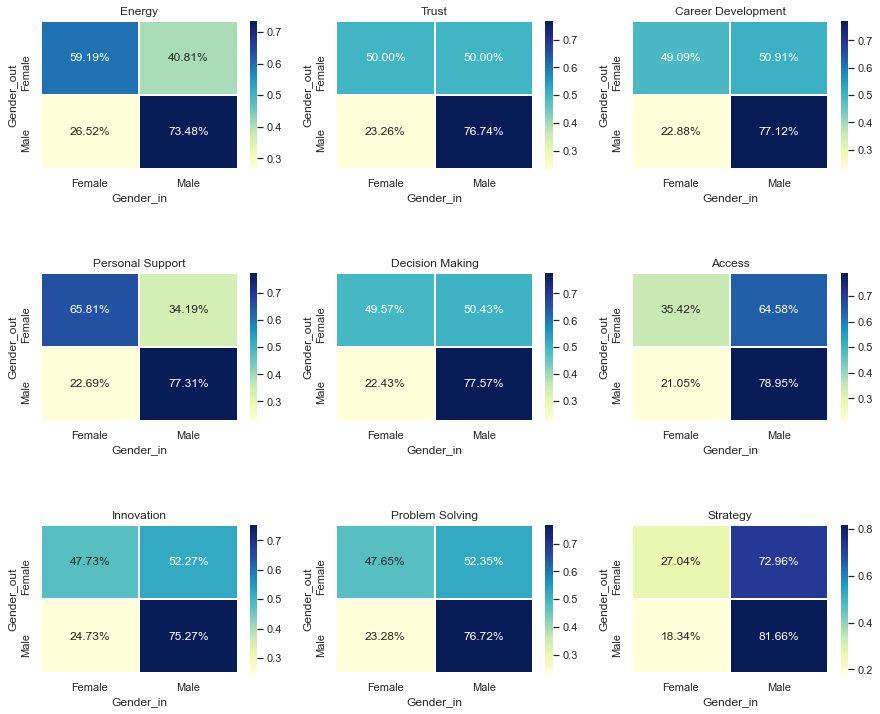

In [421]:
#Gender to gender statistics by label
label = combined['Label'].unique()
plt.figure(figsize=(15,12))

#Energy
sector_e = combined[combined['Label'] == 'Energy']
sector_group_e = sector_e.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_e = sector_group_e.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
a =sector_group_e.iloc[1,1] 
b = sector_group_e.iloc[1,0] 
c = sector_group_e.iloc[0,0]
d = sector_group_e.iloc[0,1]
sector_group_e.iloc[1,1] =  a / (a+b)
sector_group_e.iloc[1,0] =  b / (a+b)
sector_group_e.iloc[0,0] = c/(c+d)
sector_group_e.iloc[0,1] = d/(c+d)
plt.subplot(3,3,1)
sns.heatmap(data=sector_group_e,linewidths=1,annot = True, fmt = '.2%',cmap="YlGnBu")
plt.title('Energy')

#Trust
sector_t = combined[combined['Label'] == 'Trust']
sector_group_t = sector_t.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_t = sector_group_t.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
a =sector_group_t.iloc[1,1] 
b = sector_group_t.iloc[1,0] 
c = sector_group_t.iloc[0,0]
d = sector_group_t.iloc[0,1]
sector_group_t.iloc[1,1] =  a / (a+b)
sector_group_t.iloc[1,0] =  b / (a+b)
sector_group_t.iloc[0,0] =  c/(c+d)
sector_group_t.iloc[0,1] =  d/(c+d)
plt.subplot(3,3,2)
sns.heatmap(data=sector_group_t,linewidths=1,annot = True, fmt = '.2%',cmap="YlGnBu")
plt.title('Trust')

#Career Development
sector_c = combined[combined['Label'] == 'Career Development']
sector_group_c = sector_c.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_c = sector_group_c.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
a =sector_group_c.iloc[1,1] 
b = sector_group_c.iloc[1,0] 
c = sector_group_c.iloc[0,0]
d = sector_group_c.iloc[0,1]
sector_group_c.iloc[1,1] =  a / (a+b)
sector_group_c.iloc[1,0] =  b / (a+b)
sector_group_c.iloc[0,0] =  c/(c+d)
sector_group_c.iloc[0,1] =  d/(c+d)
plt.subplot(3,3,3)
sns.heatmap(data=sector_group_c,linewidths=1,annot = True, fmt = '.2%',cmap="YlGnBu")
plt.title('Career Development')


#Personal Support
sector_p = combined[combined['Label'] == 'Personal Support']
sector_group_p = sector_p.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_p = sector_group_p.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
a =sector_group_p.iloc[1,1] 
b = sector_group_p.iloc[1,0] 
c = sector_group_p.iloc[0,0]
d = sector_group_p.iloc[0,1]
sector_group_p.iloc[1,1] =  a / (a+b)
sector_group_p.iloc[1,0] =  b / (a+b)
sector_group_p.iloc[0,0] =  c/(c+d)
sector_group_p.iloc[0,1] =  d/(c+d)
plt.subplot(3,3,4)
sns.heatmap(data=sector_group_p,linewidths=1,annot = True, fmt = '.2%',cmap="YlGnBu")
plt.title('Personal Support')

#Decision Making
sector_d = combined[combined['Label'] == 'Decision Making']
sector_group_d = sector_d.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_d = sector_group_d.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
a =sector_group_d.iloc[1,1] 
b = sector_group_d.iloc[1,0] 
c = sector_group_d.iloc[0,0]
d = sector_group_d.iloc[0,1]
sector_group_d.iloc[1,1] =  a / (a+b)
sector_group_d.iloc[1,0] =  b / (a+b)
sector_group_d.iloc[0,0] =  c/(c+d)
sector_group_d.iloc[0,1] =  d/(c+d)
plt.subplot(3,3,5)
sns.heatmap(data=sector_group_d,linewidths=1,annot = True, fmt = '.2%',cmap="YlGnBu")
plt.title('Decision Making')

#Access
sector_a = combined[combined['Label'] == 'Access']
sector_group_a = sector_a.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_a = sector_group_a.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
a =sector_group_a.iloc[1,1] 
b = sector_group_a.iloc[1,0] 
c = sector_group_a.iloc[0,0]
d = sector_group_a.iloc[0,1]
sector_group_a.iloc[1,1] =  a / (a+b)
sector_group_a.iloc[1,0] =  b / (a+b)
sector_group_a.iloc[0,0] =  c/(c+d)
sector_group_a.iloc[0,1] =  d/(c+d)
plt.subplot(3,3,6)
sns.heatmap(data=sector_group_a,linewidths=1,annot = True, fmt = '.2%',cmap="YlGnBu")
plt.title('Access')

#Innovation
sector_i = combined[combined['Label'] == 'Innovation']
sector_group_i = sector_i.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_i = sector_group_i.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
a =sector_group_i.iloc[1,1] 
b = sector_group_i.iloc[1,0] 
c = sector_group_i.iloc[0,0]
d = sector_group_i.iloc[0,1]
sector_group_i.iloc[1,1] =  a / (a+b)
sector_group_i.iloc[1,0] =  b / (a+b)
sector_group_i.iloc[0,0] =  c/(c+d)
sector_group_i.iloc[0,1] =  d/(c+d)
plt.subplot(3,3,7)
sns.heatmap(data=sector_group_i,linewidths=1,annot = True, fmt = '.2%',cmap="YlGnBu")
plt.title('Innovation')

#Problem Solving
sector_r = combined[combined['Label'] == 'Problem Solving']
sector_group_r = sector_r.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_r = sector_group_r.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
a =sector_group_r.iloc[1,1] 
b = sector_group_r.iloc[1,0] 
c = sector_group_r.iloc[0,0]
d = sector_group_r.iloc[0,1]
sector_group_r.iloc[1,1] =  a / (a+b)
sector_group_r.iloc[1,0] =  b / (a+b)
sector_group_r.iloc[0,0] =  c/(c+d)
sector_group_r.iloc[0,1] =  d/(c+d)
plt.subplot(3,3,8)
sns.heatmap(data=sector_group_r,linewidths=1,annot = True, fmt = '.2%',cmap="YlGnBu")
plt.title('Problem Solving')


#Strategy
sector_s = combined[combined['Label'] == 'Strategy']
sector_group_s = sector_s.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_s = sector_group_s.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
a =sector_group_s.iloc[1,1] 
b = sector_group_s.iloc[1,0] 
c = sector_group_s.iloc[0,0]
d = sector_group_s.iloc[0,1]
sector_group_s.iloc[1,1] =  a / (a+b)
sector_group_s.iloc[1,0] =  b / (a+b)
sector_group_s.iloc[0,0] =  c/(c+d)
sector_group_s.iloc[0,1] =  d/(c+d)
plt.subplot(3,3,9)
sns.heatmap(data=sector_group_s,linewidths=1,annot = True, fmt = '.2%',cmap="YlGnBu")
plt.title('Strategy')

plt.subplots_adjust(hspace = .7)

''''for i in range(0,len(label)):
    sector = combined[combined['Label'] == label[i]]
    sector_group = sector.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
    sector_group = sector_group.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
    sns.heatmap(data=sector_group)'''

<font color = 'blue'><b>As can be seen in the heatmap for each label, men are likely connected with their own gender while women are likely connected with their own gender for specific topics such as 'Energy' and'Personal Support'. The more blue, the more connected. From this observation, it would be interesting to test two hypotheses:

1. Overall, men are more likely to connect with men and women are more likley to connect with other women
2. Women are more communicative than men

## 2. Hypothesis 1: Gender Assortativity

### a. Computing Gender Assortativity 

In order to test the first hypothesis, the assortativity coeffiicent was used to quantify the extent to which gender plays a role in networking. The assortativity coeffiicent gauges the correlation between chracteristics of connected nodes in a network just like the Pearson Correlation Coefficient does: A value always falls bewteen -1 and 1. A postitive assortativity coefficient indicates that nodes with similar characteristics tend to connect to each other. 

In [422]:
link_final2

0         (150, 8)
1       (188, 524)
2       (188, 524)
3       (188, 524)
4       (188, 524)
           ...    
5088    (494, 600)
5089    (494, 600)
5090    (494, 600)
5091    (276, 511)
5092    (276, 511)
Name: link, Length: 5093, dtype: object

In [423]:
nodes_network

,ID,Gender,Gender2
0,0,Female,2
1,1,Female,2
2,2,Female,2
3,3,Female,2
4,4,Female,2
...,...,...,...
607,607,Female,2
608,608,Male,1
609,609,Male,1
610,610,Male,1


In [424]:
link_final.isna().value_counts()

Source  Target  link 
False   False   False    5093
dtype: int64

In [425]:
link_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5093 entries, 0 to 5092
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Source  5093 non-null   int64 
 1   Target  5093 non-null   int64 
 2   link    5093 non-null   object
dtypes: int64(2), object(1)
memory usage: 159.2+ KB


In [426]:
#Link data preprocessing
a = [i for i in range(0,612)]
nodes['ID2']= a
nodes2 = nodes.rename(columns = {'ID':'Target','ID2':'ID_Target'})
link2 = link[['Source','Target']]
link2 = link2.rename(columns = {'Source' : 'ID'})
link3 = pd.merge(link2,nodes,how='left')
link4 = pd.merge(link3,nodes2,how='left',on='Target')
link_final = link4[['ID2','ID_Target']]
link_final = link_final.rename(columns = {'ID2':'Source','ID_Target':'Target'})
link_final['link'] = list(zip(link_final['Source'],link_final['Target']))
link_final2 = link_final['link']

#Node data preprocessing
nodes_network = nodes[['ID','Gender']]
nodes_network2 = nodes[['ID','Gender']]
nodes_network['Gender2'] = nodes_network['Gender'].map({'Male':1, 'Female':2})
nodes_network2['Gender2'] = nodes_network2['Gender'].map({'Female':0,'Male':1})


#Creating a network and compute the assortativity
nodes_network['ID'] = [i for i in range(0,612)]
nodes_network2['ID'] = [i for i in range(0,612)]
g = ig.Graph()
g.add_vertices([i for i in range(0,612)])
g.add_edges(link_final2)
g.vs['Gender'] = nodes_network['Gender2']
print('The assortativity of the network is {0}'.format(g.assortativity_nominal('Gender',directed=True)))

The assortativity of the network is 0.26986616946343467


<b><font color= 'blue'>Conclusion:</b><br>
   <font color= 'blue'>The assortativity coefficient of the network is 0.2698, which indicates that there are more edges between same genders compared to a random network. However, the strength of assortativity is 'weak'. 

### b. Computing Gender Assortativity by Label
The assortativity coefficients were calculated based on 'label'. 

In [427]:
link_label_final2

,link,Label
0,"(150, 8)",Energy
1,"(188, 524)",Trust
2,"(188, 524)",Career Development
3,"(188, 524)",Personal Support
4,"(188, 524)",Decision Making
...,...,...
5088,"(494, 600)",Access
5089,"(494, 600)",Personal Support
5090,"(494, 600)",Decision Making
5091,"(276, 511)",Trust


In [428]:
link_label_final

,Source,Target,Label,link
0,150,8,Energy,"(150, 8)"
1,188,524,Trust,"(188, 524)"
2,188,524,Career Development,"(188, 524)"
3,188,524,Personal Support,"(188, 524)"
4,188,524,Decision Making,"(188, 524)"
...,...,...,...,...
5088,494,600,Access,"(494, 600)"
5089,494,600,Personal Support,"(494, 600)"
5090,494,600,Decision Making,"(494, 600)"
5091,276,511,Trust,"(276, 511)"


In [429]:
#Link data preprocessing
link_label = link[['Source','Target','Label']]
link_label = link_label.rename(columns = {'Source' : 'ID'})
link_label2=pd.merge(link_label,nodes,how='left')
link_label3 = pd.merge(link_label2,nodes2,how='left', on='Target')
link_label_final = link_label3[['ID2','ID_Target','Label']]
link_label_final = link_label_final.rename(columns = {'ID2': 'Source','ID_Target':'Target'})
link_label_final['link'] = list(zip(link_label_final['Source'],link_label_final['Target']))
link_label_final2 = link_label_final[['link','Label']]

#create link data with label
labels = link_label_final2['Label'].unique()
link_data_by_label = []
for label in labels:
    new_label = link_label_final2[link_label_final2['Label'] == label]
    link_data_by_label.append(new_label)
    
    
#create a network and compute the assortativity by label    
node_final = [i for i in range(0,612)]
assortativity=[]
for datum in link_data_by_label:
    g = ig.Graph()
    g.add_vertices(node_final)
    g.add_edges(datum['link'])
    g.vs['Gender'] = nodes_network['Gender2']
    temp = g.assortativity_nominal('Gender',directed = True)
    assortativity.append(temp)
    
assortativity_label = {key: value for key, value in zip(labels,assortativity)}
assortativity_label2 = pd.DataFrame(data=list(zip(labels,assortativity)),columns =['Label','Assortativity'])

In [430]:
#print assortativity by label
assortativity_label2

,Label,Assortativity
0,Energy,0.328386
1,Trust,0.271989
2,Career Development,0.265100
3,Personal Support,0.432106
4,Decision Making,0.276716
5,Access,0.130380
6,Innovation,0.233658
7,Problem Solving,0.247229
8,Strategy,0.072249


<b><font color = 'blue'>Conclusion:</b><br>
<b><font color = 'blue'>Assortativity is high for 'Personal Support', 'Energy'and 'Decision Making'. This can be interpreted that people tend to talk to their own gender for topics such as 'Personal Support', 'Energy'and 'Decision Making'.

## 3. Hypothesis 2: Women are more communicative

### a. The difference in the number of <font color = 'red'>out-degrees </font> between men and women : Permutation and t-test

In this secton, I examined the difference in the number of out-degrees between men and women from the sample and tested if the difference is statistically significant by performing a permutation test and t-test. 

In [431]:
out_label

,ID,Label
0,150,Energy
1,188,Trust
2,188,Career Development
3,188,Personal Support
4,188,Decision Making
...,...,...
5088,494,Access
5089,494,Personal Support
5090,494,Decision Making
5091,276,Trust


In [432]:
#preprocessing the data 
out_label = link_label_final[['Source','Label']]
out_label = out_label.rename(columns = {'Source':'ID'})
out_label_gender = pd.merge(out_label,nodes_network,how = 'left',on = 'ID')
out_label_male = out_label_gender[out_label_gender['Gender'] == 'Male']
out_label_female = out_label_gender[out_label_gender['Gender'] == 'Female']
number_degree_male = out_label_male.groupby(['ID']).Gender.count().reset_index()
number_degree_male = number_degree_male.rename(columns = {'Gender': 'Number of out-degree'})
number_degree_female = out_label_female.groupby(['ID']).Gender.count().reset_index()
number_degree_female = number_degree_female.rename(columns = {'Gender':'Number of out-degree'})
number_degree_male2 = number_degree_male['Number of out-degree']
number_degree_female2 = number_degree_female['Number of out-degree']

In [433]:
#split the data into men and women in terms of # of out-degress 
nodes_network_male = nodes_network[nodes_network['Gender']=='Male']
nodes_network_male21 = pd.merge(nodes_network_male,number_degree_male,how='left',on = 'ID')
nodes_network_male2=nodes_network_male21.fillna(0)
nodes_network_female = nodes_network[nodes_network['Gender']=='Female']
nodes_network_female21 = pd.merge(nodes_network_female,number_degree_female,how='left',on = 'ID')
nodes_network_female2=nodes_network_female21.fillna(0)
nodes_network_male2 = nodes_network_male2['Number of out-degree']
nodes_network_female2 = nodes_network_female2['Number of out-degree']
average_male_out = np.mean(nodes_network_male2)
average_female_out = np.mean(nodes_network_female2)
outdegree_diff = pd.DataFrame(np.array([[average_male_out,average_female_out]]),columns = ['Male','Female'],index=['# of out-degrees'])

In [558]:
outdegree_diff

,Male,Female
# of out-degrees,7.783715,9.287671


In [435]:
nodes_network_male

,ID,Gender,Gender2
177,177,Male,1
178,178,Male,1
179,179,Male,1
180,180,Male,1
181,181,Male,1
...,...,...,...
606,606,Male,1
608,608,Male,1
609,609,Male,1
610,610,Male,1


In [436]:
outdegree_diff

,Male,Female
# of out-degrees,7.783715,9.287671


<font color = 'blue'><b>As can be seen above, the average number of out-degrees for Female is 1.504 higher than the average number of out-degrees for Male. (9.287671 vs 7.783715

Text(0.5, 1.0, 'Number of Out-degree by Gender')

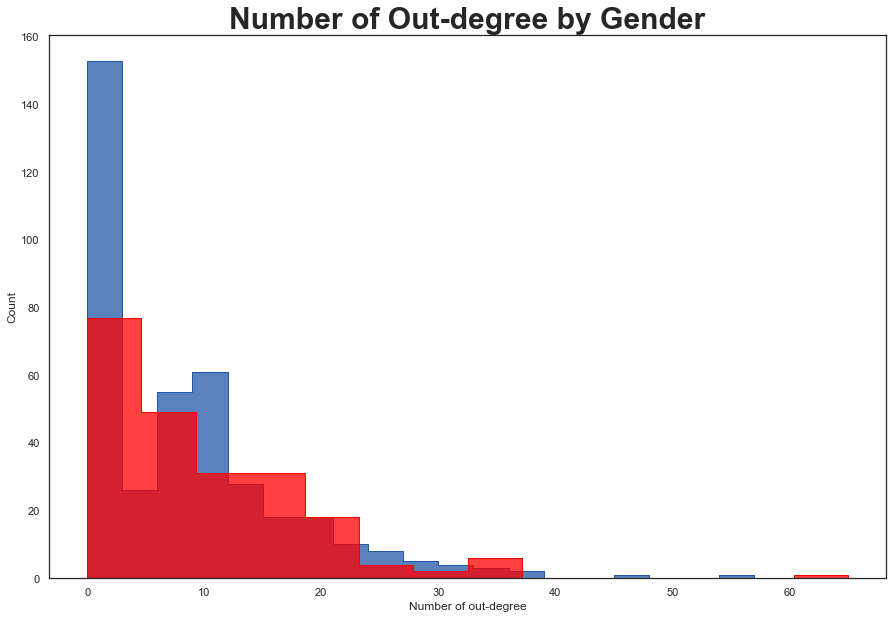

In [437]:
f,ax = plt.subplots(figsize = (15,10))
sns.histplot(nodes_network_male2,element='step',color='#2157A4')
sns.histplot(nodes_network_female2,element = 'step',color='red')

ax.set_title('Number of Out-degree by Gender',fontweight = 'bold',fontsize=30)

In [438]:
tstat,pval_ttest_out2 = ttest_ind(nodes_network_male2,nodes_network_female2)
p_val_permu_out2 = permutation_test(nodes_network_male2,nodes_network_female2,method='approximate',num_rounds = 10000,seed=0)

In [439]:
pval_ttest_out2

0.04646645411248457

In [440]:
p_val_permu_out2

0.0471952804719528

<font color= 'blue'><b>Conclusion:
    

A p-value of .047 indicates that we would see the observed sample result only 4.7% of the time under the assumption that there's no difference in the average out-degrees between men and women. Thus we reject the null hypothesis indicating that there's a statistically significant difference in the number of out-degrees betweeen men and women based on 0.05 threshold. 

### b. The difference in the number of <font color =red> in-degrees </font> between men and women : Permutation and t-test

In this section, the number of in-degrees between men and women was calculated. 

In [441]:
in_label = link_label_final[['Target','Label']]
in_label =in_label.rename(columns ={'Target':'ID'})
in_label_gender = pd.merge(in_label,nodes_network,how='left',on='ID')
in_label_male = in_label_gender[in_label_gender['Gender'] =='Male']
in_label_female = in_label_gender[in_label_gender['Gender'] =='Female']
number_in_male = in_label_male.groupby(['ID']).Gender.count().reset_index()
number_in_female = in_label_female.groupby(['ID']).Gender.count().reset_index()
number_in_male = number_in_male.rename(columns = {'Gender': 'Number of in-degree'})
number_in_female = number_in_female.rename(columns = {'Gender': 'Number of in-degree'})
nodes_network_male_in = nodes_network[nodes_network['Gender']=='Male']
nodes_network_male2_in = pd.merge(nodes_network_male_in,number_in_male,how='left',on = 'ID')
nodes_network_male3_in = nodes_network_male2_in.fillna(0)
nodes_network_female_in = nodes_network[nodes_network['Gender']=='Female']
nodes_network_female2_in = pd.merge(nodes_network_female_in,number_in_female,how='left',on = 'ID')
nodes_network_female3_in=nodes_network_female2_in.fillna(0)
nodes_network_male3_in = nodes_network_male3_in['Number of in-degree']
nodes_network_female3_in = nodes_network_female3_in['Number of in-degree']
average_male_in = np.mean(nodes_network_male3_in)
average_female_in = np.mean(nodes_network_female3_in)
indegree_diff = pd.DataFrame(np.array([[average_male_in,average_female_in]]),columns = ['Male','Female'],index=['# of in-degrees'])


In [442]:
8.5292875 - 7.835616

0.6936715000000007

In [443]:
indegree_diff

,Male,Female
# of in-degrees,8.592875,7.835616


<font color = 'blue'><b>As can be seen above, the average number of in-degrees for Male is 0.69367 higher than the average number of out-degrees for Male. (8.592875 vs 7.835616)

Text(0.5, 1.0, 'Number of In-degree by Gender')

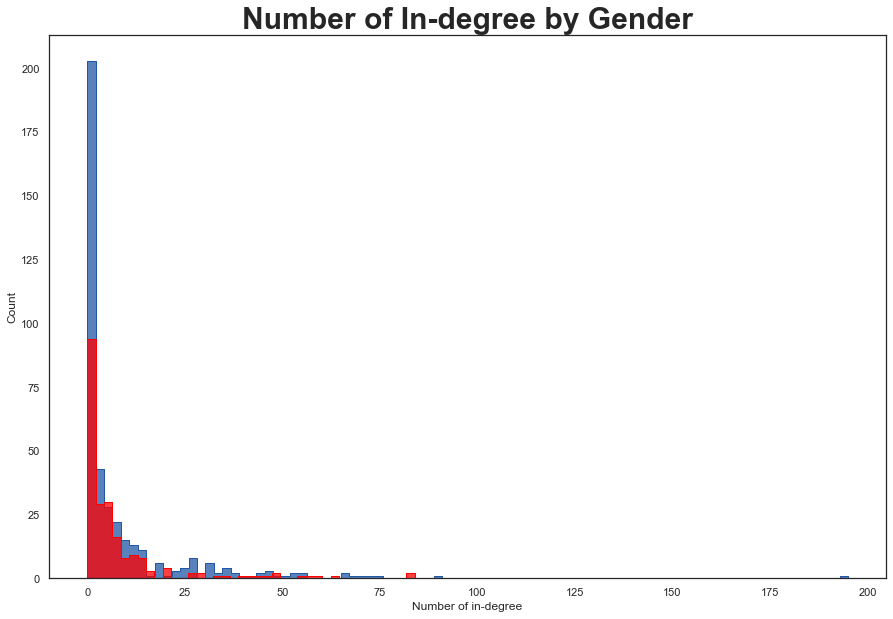

In [444]:
f,ax = plt.subplots(figsize = (15,10))
sns.histplot(nodes_network_male3_in,element='step',color='#2157A4')
sns.histplot(nodes_network_female3_in,element = 'step',color='red')

ax.set_title('Number of In-degree by Gender',fontweight = 'bold',fontsize=30)

In [445]:
tstat,pval_ttest_in2 = ttest_ind(nodes_network_male3_in,nodes_network_female3_in)
p_val_permu_in2 = permutation_test(nodes_network_male3_in,nodes_network_female3_in,method='approximate',num_rounds = 10000,seed=0)

In [446]:
pval_ttest_in2

0.5712703414065738

In [447]:
p_val_permu_in2

0.5823417658234177

<font color = blue><b>Conclusion:<br>
    
The p-value for the number of in-degrees is 0.58, which is greater than 0.05. We failed to reject the null hypothesis; in our smaple women have a higher connections, but this result is not statistically significant. In conclusion, there's no significant difference in the number of in-degrees (receiver) between men and women.

## 4. Testing the Hypothses on Different Level  (level 1: most senior level 5: least senior)

### a. Difference in average number of out-degrees by Level

In [448]:
#select columns of interst from node data 
nodes_level = nodes_all2[['ID','Gender','Level']]

#drop rows with N/A
nodes_level.dropna(subset=['ID','Gender','Level'],inplace = True)

#add a ID2 column with a series:(0,612)
nodes_level['ID2']= a
nodes_level_temp = nodes_level


#rearrange the order of columns
nodes_level_temp = nodes_level_temp[['ID2','Gender','Level']]


#encode the gender variable
nodes_level_temp['Gender2'] = nodes_level_temp['Gender'].map({'Male':1,'Female':2})
nodes_level_temp_male = nodes_level_temp[nodes_level_temp['Gender'] =='Male'].rename(columns = {'ID2':'ID'})
nodes_level_temp_female = nodes_level_temp[nodes_level_temp['Gender'] =='Female'].rename(columns = {'ID2': 'ID'})


nodes_level_temp = nodes_level_temp.rename(columns={'ID2':'Source'})
nodes_level_temp2 = nodes_level_temp.rename(columns={'Source': 'Target'})

nodes_level2 = nodes_level.rename(columns = {'ID':'Target','ID2':'ID_Target'})



<ipython-input-448-b6f260a1b386>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_level.dropna(subset=['ID','Gender','Level'],inplace = True)
<ipython-input-448-b6f260a1b386>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_level['ID2']= a


In [449]:
#link data preprocessing - male
link_level_male = pd.merge(nodes_network_male21,nodes_level_temp_male,how='left')
link_level_male = link_level_male.fillna(0)

#link data preprocessing - female
link_level_female = pd.merge(nodes_network_female21,nodes_level_temp_female,how='left')
link_level_female = link_level_female.fillna(0)


#break gender data in different levels
level_male_data = []
for i in range(1,6):
    level_male_data.append(link_level_male[link_level_male['Level'] == i])
    
level_female_data = []
for i in range(1,6):
    level_female_data.append(link_level_female[link_level_female['Level'] == i])
    
pval_by_level = []
pval_by_level_t = []
for i in range(0,5):
     pval_by_level.append(permutation_test(level_male_data[i]['Number of out-degree'],level_female_data[i]['Number of out-degree'],method='approximate',num_rounds = 10000,seed=0))
     t_stat, pvalue = ttest_ind(level_male_data[i]['Number of out-degree'],level_female_data[i]['Number of out-degree'])
     pval_by_level_t.append(pvalue)
    

level = ['Level:{0}'.format(v) for v in list(range(1,6)) ]  
level2 = ['Level {0}:[male,female]'.format(v) for v in list(range(1,6))]
level3 = ['Level:{0}'.format(v) for v in list(range(1,6))]

pval_by_level2 = [(level,pval) for level,pval in zip(level,pval_by_level)]
pval_by_level_t2 = [(level,pval) for level,pval in zip(level,pval_by_level_t)]        
        
pval_by_level_table = pd.DataFrame(list(zip(level,pval_by_level_t)),columns = ['Level','P-value'])
    

/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [450]:
pval_by_level_table

,Level,P-value
0,Level:1,NaN
1,Level:2,0.131013
2,Level:3,0.604524
3,Level:4,0.318692
4,Level:5,0.002616


In [451]:
pval_by_level_t2

[('Level:1', nan),
 ('Level:2', 0.13101252402855024),
 ('Level:3', 0.6045241112974844),
 ('Level:4', 0.31869237839015446),
 ('Level:5', 0.002615686787267152)]

In [452]:
#find the number of data by gender and level
male_n = []
female_n = []
for i in range(0,5):
    male_n.append(len(level_male_data[i]))
    female_n.append(len(level_female_data[i]))
n_by_level = list(zip(male_n,female_n))  
n_by_level = dict(zip(level2,n_by_level))

In [453]:
n_by_level

{'Level 1:[male,female]': (1, 0),
 'Level 2:[male,female]': (7, 2),
 'Level 3:[male,female]': (42, 23),
 'Level 4:[male,female]': (126, 123),
 'Level 5:[male,female]': (217, 71)}

In [454]:
#find the average number of out-degrees by gender and level
male_mean_degree = []
female_mean_degree = []
for i in range(0,5):
    male_mean_degree.append(level_male_data[i]['Number of out-degree'].mean())
    female_mean_degree.append(level_female_data[i]['Number of out-degree'].mean())
    
mean_degree_level = list(zip(male_mean_degree,female_mean_degree))  
mean_degree_level = dict(zip(level3,mean_degree_level))

mean_degree_level_table = pd.DataFrame(list(zip(level3,male_mean_degree,female_mean_degree)),columns=['Level','Male','Female'])

In [455]:
mean_degree_level_table

,Level,Male,Female
0,Level:1,10.000000,NaN
1,Level:2,12.571429,5.500000
2,Level:3,11.119048,12.347826
3,Level:4,10.119048,8.934959
4,Level:5,5.617512,9.014085


### a. Difference in average number of in-degrees by Level

In [456]:
nodes_network_male2_in

,ID,Gender,Gender2,Number of in-degree
0,177,Male,1,6.0
1,178,Male,1,NaN
2,179,Male,1,11.0
3,180,Male,1,NaN
4,181,Male,1,4.0
...,...,...,...,...
388,606,Male,1,13.0
389,608,Male,1,53.0
390,609,Male,1,73.0
391,610,Male,1,195.0


In [457]:
link_level_male_in

,ID,Gender,Gender2,Number of in-degree,Level
0,177,Male,1,6.0,4.0
1,178,Male,1,0.0,4.0
2,179,Male,1,11.0,4.0
3,180,Male,1,0.0,4.0
4,181,Male,1,4.0,5.0
...,...,...,...,...,...
388,606,Male,1,13.0,2.0
389,608,Male,1,53.0,2.0
390,609,Male,1,73.0,2.0
391,610,Male,1,195.0,1.0


In [458]:
link_level_male_in[link_level_male_in['Level']== 5]

,ID,Gender,Gender2,Number of in-degree,Level
4,181,Male,1,4.0,5.0
6,183,Male,1,1.0,5.0
9,186,Male,1,1.0,5.0
12,189,Male,1,0.0,5.0
13,190,Male,1,0.0,5.0
...,...,...,...,...,...
378,592,Male,1,0.0,5.0
380,594,Male,1,0.0,5.0
381,595,Male,1,0.0,5.0
382,596,Male,1,8.0,5.0


In [459]:
#link data preprocessing - male
link_level_male_in = pd.merge(nodes_network_male2_in,nodes_level_temp_male,how='left')
link_level_male_in = link_level_male_in.fillna(0)

#link data preprocessing - female
link_level_female_in = pd.merge(nodes_network_female2_in,nodes_level_temp_female,how='left')
link_level_female_in = link_level_female_in.fillna(0)


#split gender data in five different levels
level_male_data_in = []
for i in range(1,6):
    level_male_data_in.append(link_level_male_in[link_level_male_in['Level'] == i])
    
level_female_data_in = []
for i in range(1,6):
    level_female_data_in.append(link_level_female_in[link_level_female_in['Level'] == i])
    
pval_by_level_in = []
pval_by_level_t_in = []
for i in range(0,5):
    pval_by_level_in.append(permutation_test(level_male_data_in[i]['Number of in-degree'],level_female_data_in[i]['Number of in-degree'],method='approximate',num_rounds = 10000,seed=0))
    tstat2,pval2 = ttest_ind(level_male_data_in[i]['Number of in-degree'],level_female_data_in[i]['Number of in-degree'])
    pval_by_level_t_in.append(pval2)


level = ['Level:{0}'.format(v) for v in list(range(1,6)) ]  
level2 = ['Level {0}:[male,female]'.format(v) for v in list(range(1,6))]
level3 = ['Level:{0}'.format(v) for v in list(range(1,6))]

pval_by_level2_in = [(level,pval) for level,pval in zip(level,pval_by_level_in)]
pval_by_level_t2_in = [(level,pval) for level,pval in zip(level,pval_by_level_t_in)]        

pval_by_level_t2_table = pd.DataFrame(list(zip(level,pval_by_level_t_in)),columns = ['Level','P-value'])
    

/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [460]:
pval_by_level_t2_table

,Level,P-value
0,Level:1,NaN
1,Level:2,0.863937
2,Level:3,0.302548
3,Level:4,0.638346
4,Level:5,0.761809


In [461]:
pval_by_level_t2_in

[('Level:1', nan),
 ('Level:2', 0.8639365731351777),
 ('Level:3', 0.3025483504916912),
 ('Level:4', 0.638346003573503),
 ('Level:5', 0.761809144213205)]

In [462]:
#find the number of datapoints by gender and level
male_n_in = []
female_n_in = []
for i in range(0,5):
    male_n_in.append(len(level_male_data_in[i]))
    female_n_in.append(len(level_female_data_in[i]))
n_by_level_in = list(zip(male_n_in,female_n_in))  
n_by_level_in = dict(zip(level2,n_by_level_in))

In [463]:
n_by_level_in

{'Level 1:[male,female]': (1, 0),
 'Level 2:[male,female]': (7, 2),
 'Level 3:[male,female]': (42, 23),
 'Level 4:[male,female]': (126, 123),
 'Level 5:[male,female]': (217, 71)}

In [464]:
#find the average number of out-degrees by gender and level
male_mean_in_degree = []
female_mean_in_degree = []
for i in range(0,5):
    male_mean_in_degree.append(level_male_data_in[i]['Number of in-degree'].mean())
    female_mean_in_degree.append(level_female_data_in[i]['Number of in-degree'].mean())
    
mean_degree_level_in = list(zip(male_mean_in_degree,female_mean_in_degree))  
mean_degree_level_in = dict(zip(level3,mean_degree_level_in))

mean_degree_level_in_table = pd.DataFrame(list(zip(level3,male_mean_in_degree,female_mean_in_degree)),columns=['Level','Male','Female'])

In [465]:
mean_degree_level_in_table

,Level,Male,Female
0,Level:1,195.000000,NaN
1,Level:2,49.714286,44.500000
2,Level:3,29.571429,23.695652
3,Level:4,7.619048,7.008130
4,Level:5,2.912442,3.098592


## Gender Assortativity by Level

I would like to compute gender assortativity by level. My hypothesis is that level 5 has the highest gender assortativity because they do not have any responsibility of being connected. 

In [574]:
link_level_assort2

,link,Level
0,"(150, 8)",3.0
1,"(188, 524)",4.0
2,"(188, 524)",4.0
3,"(188, 524)",4.0
4,"(188, 524)",4.0
...,...,...
5088,"(494, 600)",3.0
5089,"(494, 600)",3.0
5090,"(494, 600)",3.0
5091,"(276, 511)",3.0


In [466]:
link_level = link_label_final[['Source','Target','link']]
link_level_assort = pd.merge(link_level,nodes_level_temp,how='left',on='Source')
nodes_level_temp_target = nodes_level_temp.rename(columns ={'Source':'Target'})
link_level_assort2=link_level_assort[['link','Level']]

link_level_assort_full = pd.merge(link_level_assort,nodes_level_temp_target,how='left',on='Target')
#create link data with level
levels = nodes_level_temp['Level'].unique()
levels.sort()
link_data_by_level = []
for level in levels:
    new_level = link_level_assort2[link_level_assort2['Level'] == level]
    link_data_by_level.append(new_level)
    
    
#create a network and compute the assortativity by label    
node_final_assort = [i for i in range(0,612)]
assortativity_level=[]
for datum in link_data_by_level:
    g = ig.Graph()
    g.add_vertices(node_final)
    g.add_edges(datum['link'])
    g.vs['Gender'] = nodes_network['Gender2']
    temp = g.assortativity_nominal('Gender',directed = True)
    assortativity_level.append(temp)
    
assortativity_level2 = {key: value for key, value in zip(levels,assortativity_level)}
assortativity_level3 = pd.DataFrame(list(zip(levels,assortativity_level)), columns = ['Level','Assortativity'])

In [467]:
link_level_assort_full = pd.merge(link_level_assort,nodes_level_temp_target,how='left',on='Target')

In [468]:
level5 = link_level_assort_full[link_level_assort_full['Level_x'] == 5]

In [469]:
level5.Level_y.value_counts()

4.0    750
5.0    721
3.0    333
2.0     42
1.0     13
Name: Level_y, dtype: int64

In [470]:
assortativity_level3

,Level,Assortativity
0,1.0,-0.111111
1,2.0,-0.109137
2,3.0,0.240024
3,4.0,0.122820
4,5.0,0.476396


<font color = blue><b>Conclusion:<br>

<font color = blue><b> As can be seen in the table above, the least senior network (level 5) is strongly assortative (r = 0.48)

In [586]:
link_level_assort2

,link,Level
0,"(150, 8)",3.0
1,"(188, 524)",4.0
2,"(188, 524)",4.0
3,"(188, 524)",4.0
4,"(188, 524)",4.0
...,...,...
5088,"(494, 600)",3.0
5089,"(494, 600)",3.0
5090,"(494, 600)",3.0
5091,"(276, 511)",3.0


In [593]:
level45

,link,Level
15,"(521, 191)",5.0
16,"(521, 191)",5.0
17,"(521, 529)",5.0
18,"(521, 182)",5.0
19,"(521, 182)",5.0
...,...,...
4737,"(173, 174)",5.0
4738,"(173, 167)",5.0
4739,"(173, 167)",5.0
4983,"(566, 171)",5.0


In [597]:
level45 = link_level_assort2[(link_level_assort2['Level'] == 4) | (link_level_assort2['Level'] == 5)]

In [598]:
level45.Level.value_counts()

4.0    2374
5.0    1859
Name: Level, dtype: int64

In [600]:
level45

,link,Level
1,"(188, 524)",4.0
2,"(188, 524)",4.0
3,"(188, 524)",4.0
4,"(188, 524)",4.0
5,"(188, 524)",4.0
...,...,...
5068,"(541, 598)",4.0
5069,"(544, 511)",4.0
5071,"(223, 508)",4.0
5072,"(223, 508)",4.0


In [601]:
link_level = link_label_final[['Source','Target','link']]
link_level_assort = pd.merge(link_level,nodes_level_temp,how='left',on='Source')
nodes_level_temp_target = nodes_level_temp.rename(columns ={'Source':'Target'})
link_level_assort2=link_level_assort[['link','Level']]

link_level_assort_full = pd.merge(link_level_assort,nodes_level_temp_target,how='left',on='Target')
#create link data with level
levels = nodes_level_temp['Level'].unique()
levels.sort()
level45 = link_level_assort2[(link_level_assort2['Level'] == 4) | (link_level_assort2['Level'] == 5)]
    
#create a network and compute the assortativity by label    
node_final_assort = [i for i in range(0,612)]
g = ig.Graph()
g.add_vertices(node_final)
g.add_edges(level45['link'])
g.vs['Gender'] = nodes_network['Gender2']
temp = g.assortativity_nominal('Gender',directed = True)
print('The assortativity of the level45 network is {0}'.format(g.assortativity_nominal('Gender',directed=True)))
 

The assortativity of the level45 network is 0.2753586445653689


# More tests and experiements (appendix)

## Number of in-degree by Gender (without outliers)
We visually detected a couple of outliers from the histograms aboves. Since these outliers tend to be more seniors, they migth have been responsible for having more connections. Assuming that this interpretation is true, we thought that eliminating outliers might help reduce noise.

In [471]:
number_in_male_outlier = number_in_male[number_in_male['ID'] !=610]
number_in_female_outlier = number_in_female[number_in_female['ID'] != 607]
nodes_network_male_in = nodes_network[nodes_network['Gender']=='Male']
nodes_network_male_in_outlier = nodes_network_male_in[nodes_network_male_in['ID']!=610]
nodes_network_male2_in_outlier = pd.merge(nodes_network_male_in_outlier,number_in_male_outlier,how='left',on = 'ID')
nodes_network_male3_in_outlier = nodes_network_male2_in_outlier.fillna(0)
nodes_network_female_in = nodes_network[nodes_network['Gender']=='Female']
nodes_network_female_in_outlier = nodes_network_female_in[nodes_network_female_in['ID'] != 607]
nodes_network_female2_in_outlier = pd.merge(nodes_network_female_in_outlier,number_in_female_outlier,how='left',on = 'ID')
nodes_network_female3_in_outlier=nodes_network_female2_in_outlier.fillna(0)
nodes_network_male3_in_o = nodes_network_male3_in_outlier['Number of in-degree']
nodes_network_female3_in_o = nodes_network_female3_in_outlier['Number of in-degree']


Text(0.5, 1.0, 'Number of In-degree by Gender')

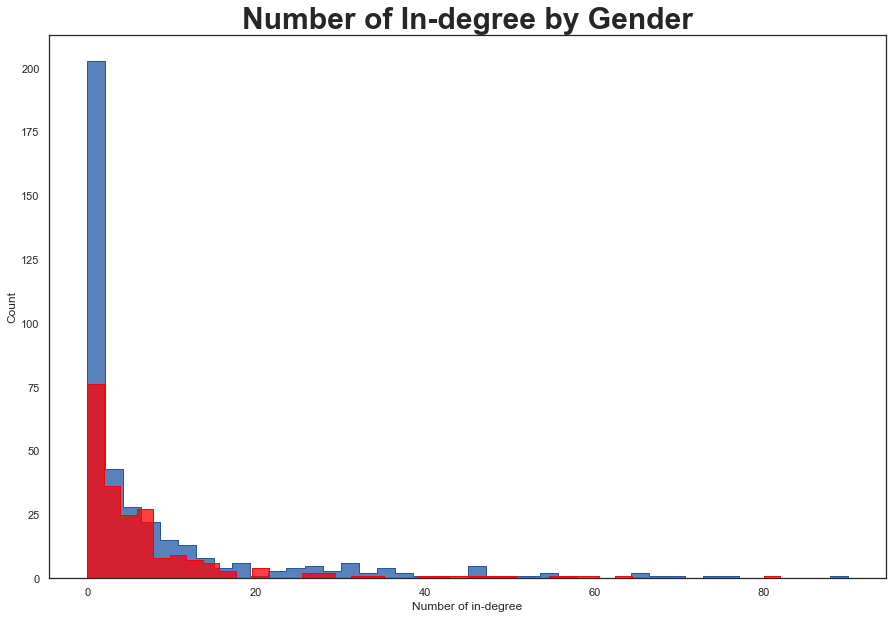

In [472]:
f,ax = plt.subplots(figsize = (15,10))
sns.histplot(nodes_network_male3_in_o,element='step',color='#2157A4')
sns.histplot(nodes_network_female3_in_o,element = 'step',color='red')

ax.set_title('Number of In-degree by Gender',fontweight = 'bold',fontsize=30)

In [473]:
tstat,pval_ttest_in2 = ttest_ind(nodes_network_male3_in_o,nodes_network_female3_in_o)
p_val_permu_in2 = permutation_test(nodes_network_male3_in_o,nodes_network_female3_in_o,method='approximate',num_rounds = 10000,seed=0)

In [474]:
pval_ttest_in2

0.5833244325643967

In [475]:
p_val_permu_in2

0.5807419258074192

<font color = blue><b>Conclusion:</b><br>
Even without top 3 outliers from both men and women groups, the p-value of .58 tells us that there's no statistical significant differences in the number of in-dgrees between them. 

## Number of Out-degrees by 'Gender' and 'Label'
raw data: out_label_gender  -> out_label_male , out_label_female

In [476]:
#number of out-degrees by gender and label
number_degree_male_label = out_label_male.groupby(['ID','Label']).Gender.count().reset_index()
number_degree_female_label = out_label_female.groupby(['ID','Label']).Gender.count().reset_index()

#group the above data by label 
out_data_label_male = []
for label in labels:
    new_label = number_degree_male_label[number_degree_male_label['Label'] == label]
    out_data_label_male.append(new_label)
    
out_data_label_female = []
for label in labels:
    new_label = number_degree_female_label[number_degree_female_label['Label'] == label]
    out_data_label_female.append(new_label)

    
#permutation test to see if there's significant difference in the average number of out-degrees by gender and label
p_val_permu_out_label = []
for i in range(9):
    p_val_permu_out_label.append(permutation_test(out_data_label_male[i].Gender,out_data_label_female[i].Gender,method='approximate',num_rounds = 10000,seed=0))

#create a list: (label,p-value)
p_val_by_label = [(label,pval) for label, pval in list(zip(labels,p_val_permu_out_label))]

print('p-values for difference in averge out-degree by label')
p_val_by_label

p-values for difference in averge out-degree by label


[('Energy', 0.11018898110188981),
 ('Trust', 0.616938306169383),
 ('Career Development', 0.31786821317868214),
 ('Personal Support', 0.0034996500349965005),
 ('Decision Making', 0.9222077792220778),
 ('Access', 0.51994800519948),
 ('Innovation', 0.7030296970302969),
 ('Problem Solving', 0.7081291870812919),
 ('Strategy', 0.37066293370662934)]


For only personal support, there's a statistical significance in # of outdegree difference between men and women

In [477]:
#average number of out-degrees by gender and label
mean_by_label_male = []
mean_by_label_female = []
for i in range(9):
    mean_by_label_male.append(out_data_label_male[i].Gender.mean())
    mean_by_label_female.append(out_data_label_female[i].Gender.mean())
mean_by_label = list(zip(mean_by_label_male,mean_by_label_female))

#create a list: [label,mean(men,women)]
mean_by_label = [(label,mean) for label,mean in zip(labels,mean_by_label)]

#print the list
print('average # of out-degrees for men and women by label ')
mean_by_label

average # of out-degrees for men and women by label 


[('Energy', (2.109004739336493, 2.450381679389313)),
 ('Trust', (1.9907407407407407, 2.0757575757575757)),
 ('Career Development', (1.4047619047619047, 1.5137614678899083)),
 ('Personal Support', (1.6049382716049383, 2.0172413793103448)),
 ('Decision Making', (1.730593607305936, 1.7164179104477613)),
 ('Access', (1.75, 1.9591836734693877)),
 ('Innovation', (2.1123595505617976, 2.018348623853211)),
 ('Problem Solving', (2.0688073394495414, 2.143884892086331)),
 ('Strategy', (1.6778846153846154, 1.5555555555555556))]

As can be seen, other areas have simliar average connections betweeen men and women except 'Personal Support'

## Gender Assortativity by Division

In [478]:
nodes_all2 = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Nodes with attributes_V2.csv')

In [479]:
#select columns of interst from node data 
nodes_div = nodes_all2[['ID','Gender','Division']]

#drop rows with N/A
nodes_div.dropna(subset=['ID','Gender','Division'],inplace = True)

#add a ID2 column with a series:(0,612)
nodes_div['ID2']= a
nodes_div_temp = nodes_div

#rearrange the order of columns
nodes_div_temp = nodes_div_temp[['ID2','Gender','Division']]


#encode the gender variable
nodes_div_temp['Gender2'] = nodes_div_temp['Gender'].map({'Male':1,'Female':2})

#create a division name list
divisions = nodes_div.Division.unique()
nodes_division = []
for division in divisions:
    nodes_division.append(nodes_div_temp[nodes_div_temp['Division'] == division])
    

#create a division size list
division_size = []
for i in range(len(divisions)):
    division_size.append(len(nodes_division[i]))


#combine division names and division size into a list
division_size = [(divisions,size) for divisions,size in list(zip(divisions,division_size))]

<ipython-input-479-aceb3dc02e28>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_div.dropna(subset=['ID','Gender','Division'],inplace = True)
<ipython-input-479-aceb3dc02e28>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_div['ID2']= a


In [480]:
#Link data preprocessing
nodes_div2 = nodes_div.rename(columns = {'ID':'Target','ID2':'ID_Target'})
link_div = link[['Source','Target']]
link_div = link_div.rename(columns = {'Source' : 'ID'})
link_div2 = pd.merge(link_div,nodes_div,how='left')
link_div3 = pd.merge(link_div2,nodes_div2,how='left',on='Target')
link_div4 = link_div3[['ID2','ID_Target','Division_x']]
link_final_div = link_div4.rename(columns = {'ID2':'Source','ID_Target':'Target','Division_x':'Division_source'})
link_final_div['link'] = list(zip(link_final_div['Source'],link_final_div['Target']))
link_final_div = link_final_div[['link','Division_source']]

link_by_div = []
for division in divisions:
    link_by_div.append(link_final_div[link_final_div['Division_source'] == division])

In [481]:
total_div = []
male_female_div = []
male_male_div = []
female_male_div = []
female_female_div = []
for i in range(len(divisions)):
    total_div.append(len(link_div3[link_div3['Division_x']==divisions[i]]))
    male_female_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Male') &(link_div3['Gender_y'] =='Female')]))
    male_male_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Male') &(link_div3['Gender_y'] =='Male')]))
    female_female_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Female') &(link_div3['Gender_y'] =='Female')]))
    female_male_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Female') &(link_div3['Gender_y'] =='Male')]))

link_distribution_division = pd.DataFrame(list(zip(total_div,male_male_div,male_female_div,female_female_div,female_male_div)),columns = ['total links','male to male','male to female','female to female','female to male'],
                                         index = [division for division in divisions ])
    

In [482]:
list(zip(total_div,male_male_div,male_female_div,female_female_div,female_male_div))

[(327, 109, 49, 117, 52),
 (826, 242, 61, 255, 268),
 (607, 145, 154, 176, 132),
 (205, 88, 21, 26, 70),
 (509, 232, 82, 78, 117),
 (522, 151, 108, 165, 98),
 (1351, 1129, 75, 25, 122),
 (637, 180, 135, 167, 155),
 (109, 77, 21, 1, 10)]

In [483]:
#Creating a network and compute the assortativity
assort_by_div = []
for i in range(len(divisions)):
    g1 = ig.Graph()
    g1.add_vertices([i for i in range(0,612)])
    g1.add_edges(link_by_div[i]['link'])
    g1.vs['Gender'] = nodes_network['Gender2']
    assort_by_div.append(g1.assortativity_nominal('Gender',directed=True))

assort_div = [(division,assortativity) for division,assortativity in zip(divisions,assort_by_div)]

In [484]:
assort_by_div

[0.3818930426238713,
 0.20319246100685065,
 0.055196360153256706,
 0.022812393598910505,
 0.13928579015571557,
 0.21015983076742273,
 0.12218475061223537,
 0.08910256410256412,
 -0.1069615069615072]

In [485]:
link_distribution_division['Assortativity'] = assort_by_div

In [486]:
#find the average number of out-degrees by gender and level
male_total_degree = []
female_total_degree = []
for i in range(0,5):
    male_total_degree.append(level_male_data[i]['Number of out-degree'].sum())
    female_total_degree.append(level_female_data[i]['Number of out-degree'].sum())
    
sum_degree_level = list(zip(male_total_degree,female_total_degree))  
sum_degree_level = dict(zip(level3,sum_degree_level))

sum_degree_level_table = pd.DataFrame(list(zip(level3,male_total_degree,female_total_degree)),columns=['Level','Male','Female'])

In [487]:
sum_degree_level_table['Total_out_degree'] = sum_degree_level_table['Male'] + sum_degree_level_table['Female']

In [488]:
sum_degree_level_table['Total_n'] = [1,9,65,249,288]

In [489]:
sum_degree_level_table['Avg_out_degree'] = sum_degree_level_table['Total_out_degree']/sum_degree_level_table['Total_n']

In [490]:
sum_degree_level_table

,Level,Male,Female,Total_out_degree,Total_n,Avg_out_degree
0,Level:1,10.0,0.0,10.0,1,10.000000
1,Level:2,88.0,11.0,99.0,9,11.000000
2,Level:3,467.0,284.0,751.0,65,11.553846
3,Level:4,1275.0,1099.0,2374.0,249,9.534137
4,Level:5,1219.0,640.0,1859.0,288,6.454861


In [491]:
sum_degree_level_table = sum_degree_level_table[['Level','Avg_out_degree']]

In [492]:
sum_degree_level_table

,Level,Avg_out_degree
0,Level:1,10.000000
1,Level:2,11.000000
2,Level:3,11.553846
3,Level:4,9.534137
4,Level:5,6.454861


In [493]:
n_by_level

{'Level 1:[male,female]': (1, 0),
 'Level 2:[male,female]': (7, 2),
 'Level 3:[male,female]': (42, 23),
 'Level 4:[male,female]': (126, 123),
 'Level 5:[male,female]': (217, 71)}

In [494]:
#find the average number of out-degrees by gender and level
male_total_in_degree = []
female_total_in_degree = []
for i in range(0,5):
    male_total_in_degree.append(level_male_data_in[i]['Number of in-degree'].sum())
    female_total_in_degree.append(level_female_data_in[i]['Number of in-degree'].sum())
    
total_degree_level_in = list(zip(male_total_in_degree,female_total_in_degree))  
total_degree_level_in = dict(zip(level3,mean_degree_level_in))

total_degree_level_in_table = pd.DataFrame(list(zip(level3,male_total_in_degree,female_total_in_degree)),columns=['Level','Male','Female'])

In [495]:
total_degree_level_in_table

,Level,Male,Female
0,Level:1,195.0,0.0
1,Level:2,348.0,89.0
2,Level:3,1242.0,545.0
3,Level:4,960.0,862.0
4,Level:5,632.0,220.0


In [496]:
total_degree_level_in_table['Total_in_degree'] = total_degree_level_in_table['Male']+total_degree_level_in_table['Female']

In [497]:
total_degree_level_in_table

,Level,Male,Female,Total_in_degree
0,Level:1,195.0,0.0,195.0
1,Level:2,348.0,89.0,437.0
2,Level:3,1242.0,545.0,1787.0
3,Level:4,960.0,862.0,1822.0
4,Level:5,632.0,220.0,852.0


In [498]:
total_degree_level_in_table['Total_n'] = [1,9,65,249,288]

In [499]:
total_degree_level_in_table

,Level,Male,Female,Total_in_degree,Total_n
0,Level:1,195.0,0.0,195.0,1
1,Level:2,348.0,89.0,437.0,9
2,Level:3,1242.0,545.0,1787.0,65
3,Level:4,960.0,862.0,1822.0,249
4,Level:5,632.0,220.0,852.0,288


In [500]:
total_degree_level_in_table['Avg_in_degree'] = total_degree_level_in_table['Total_in_degree']/total_degree_level_in_table['Total_n']

In [501]:
total_degree_level_in_table

,Level,Male,Female,Total_in_degree,Total_n,Avg_in_degree
0,Level:1,195.0,0.0,195.0,1,195.000000
1,Level:2,348.0,89.0,437.0,9,48.555556
2,Level:3,1242.0,545.0,1787.0,65,27.492308
3,Level:4,960.0,862.0,1822.0,249,7.317269
4,Level:5,632.0,220.0,852.0,288,2.958333


# Level 5 - Is this the purest network for assortativity?

In [524]:
link_level_assort_full['Label']  = link_label_final['Label']

In [525]:
link_level_assort_full

,Source,Target,link,Gender_x,Level_x,Gender2_x,Gender_y,Level_y,Gender2_y,Label
0,150,8,"(150, 8)",Female,3.0,2,Female,3.0,2,Energy
1,188,524,"(188, 524)",Male,4.0,1,Male,4.0,1,Trust
2,188,524,"(188, 524)",Male,4.0,1,Male,4.0,1,Career Development
3,188,524,"(188, 524)",Male,4.0,1,Male,4.0,1,Personal Support
4,188,524,"(188, 524)",Male,4.0,1,Male,4.0,1,Decision Making
...,...,...,...,...,...,...,...,...,...,...
5088,494,600,"(494, 600)",Male,3.0,1,Male,3.0,1,Access
5089,494,600,"(494, 600)",Male,3.0,1,Male,3.0,1,Personal Support
5090,494,600,"(494, 600)",Male,3.0,1,Male,3.0,1,Decision Making
5091,276,511,"(276, 511)",Male,3.0,1,Male,3.0,1,Trust


In [526]:
level5_in = link_level_assort_full[link_level_assort_full['Level_y'] == 5]
level5_in_male = level5_in[level5_in['Gender_y'] == 'Male']
level5_in_female = level5_in[level5_in['Gender_y'] == 'Female']
level4_in = link_level_assort_full[link_level_assort_full['Level_y'] == 4]
level4_in_male = level4_in[level4_in['Gender_y'] == 'Male']
level4_in_female = level4_in[level4_in['Gender_y'] == 'Female']

In [527]:
labels

array(['Energy', 'Trust', 'Career Development', 'Personal Support',
       'Decision Making', 'Access', 'Innovation', 'Problem Solving',
       'Strategy'], dtype=object)

In [537]:
level5_in

,Source,Target,link,Gender_x,Level_x,Gender2_x,Gender_y,Level_y,Gender2_y,Label
28,189,181,"(189, 181)",Male,5.0,1,Male,5.0,1,Personal Support
29,189,183,"(189, 183)",Male,5.0,1,Male,5.0,1,Access
39,185,181,"(185, 181)",Male,4.0,1,Male,5.0,1,Trust
40,185,181,"(185, 181)",Male,4.0,1,Male,5.0,1,Personal Support
67,530,181,"(530, 181)",Male,5.0,1,Male,5.0,1,Innovation
...,...,...,...,...,...,...,...,...,...,...
4763,153,155,"(153, 155)",Female,4.0,2,Female,5.0,2,Personal Support
4887,599,162,"(599, 162)",Female,4.0,2,Female,5.0,2,Access
4888,599,162,"(599, 162)",Female,4.0,2,Female,5.0,2,Energy
4943,170,162,"(170, 162)",Female,4.0,2,Female,5.0,2,Personal Support


In [548]:
raw_level5_label = []
for label in labels:
    temp = level5_in[level5_in['Label'] == label]
    raw_level5_label.append(temp)

raw_level5_label_male = []
for label in labels:
    temp = level5_in_male[level5_in_male['Label'] == label]
    raw_level5_label_male.append(temp)

raw_level5_label_female = []
for label in labels:
    temp = level5_in_female[level5_in_female['Label'] == label]
    raw_level5_label_female.append(temp)

In [551]:
avg5_in_by_label = []
for i in range(0,9):
    n=217+71
    temp = raw_level5_label[i].groupby('Target').Gender_y.count().reset_index()
    total_c = temp.Gender_y.sum()
    avg = total_c / n
    avg5_in_by_label.append(avg)


avg5_in_by_label_male = []
for i in range(0,9):
    n = 217
    temp = raw_level5_label_male[i].groupby('Target').Gender_y.count().reset_index()
    total_c = temp.Gender_y.sum()
    avg = total_c/n
    avg5_in_by_label_male.append(avg)

avg5_in_by_label_female = []
for i in range(0,9):
    n = 71
    temp = raw_level5_label_female[i].groupby('Target').Gender_y.count().reset_index()
    total_c = temp.Gender_y.sum()
    avg = total_c/n
    avg5_in_by_label_female.append(avg)

In [555]:
raw_level4_label = []
for label in labels:
    temp = level4_in[level4_in['Label'] == label]
    raw_level4_label.append(temp)


raw_level4_label_male = []
for label in labels:
    temp = level4_in_male[level4_in_male['Label'] == label]
    raw_level4_label_male.append(temp)

raw_level4_label_female = []
for label in labels:
    temp = level4_in_female[level4_in_female['Label'] == label]
    raw_level4_label_female.append(temp)

In [556]:
avg4_in_by_label = []
for i in range(0,9):
    n=126+123
    temp = raw_level4_label[i].groupby('Target').Gender_y.count().reset_index()
    total_c = temp.Gender_y.sum()
    avg = total_c / n
    avg4_in_by_label.append(avg)


avg4_in_by_label_male = []
for i in range(0,9):
    n = 126
    temp = raw_level4_label_male[i].groupby('Target').Gender_y.count().reset_index()
    total_c = temp.Gender_y.sum()
    avg = total_c/n
    avg4_in_by_label_male.append(avg)

avg4_in_by_label_female = []
for i in range(0,9):
    n = 123
    temp = raw_level4_label_female[i].groupby('Target').Gender_y.count().reset_index()
    total_c = temp.Gender_y.sum()
    avg = total_c/n
    avg4_in_by_label_female.append(avg)

In [571]:
in_degree_level5_label = pd.DataFrame(index=labels,columns=['Men','Women','Total'],data=list(zip(avg5_in_by_label_male,avg5_in_by_label_female,avg5_in_by_label)))
in_degree_level4_label = pd.DataFrame(index=labels,columns=['Men','Women','Total'],data=list(zip(avg4_in_by_label_male,avg4_in_by_label_female,avg4_in_by_label)))

In [678]:
new_level5_table1 = new_level5_table.iloc[0:18,:]
new_level4_table1 = new_level4_table.iloc[0:18,:]

In [680]:
new_level4_table1

,label,Avg_in_degree,Gender
0,Energy,1.134921,Male
1,Trust,1.142857,Male
2,Career Development,0.611111,Male
3,Personal Support,0.833333,Male
4,Decision Making,0.984127,Male
5,Access,0.317460,Male
6,Innovation,0.968254,Male
7,Problem Solving,1.071429,Male
8,Strategy,0.555556,Male
9,Energy,1.365854,Female


In [686]:
in_degree_level5_label

,Men,Women,Total
Energy,0.539171,0.760563,0.593750
Trust,0.479263,0.408451,0.461806
Career Development,0.092166,0.154930,0.107639
Personal Support,0.350230,0.718310,0.440972
Decision Making,0.304147,0.267606,0.295139
Access,0.152074,0.112676,0.142361
Innovation,0.447005,0.295775,0.409722
Problem Solving,0.516129,0.380282,0.482639
Strategy,0.032258,0.000000,0.024306


Text(0.5, 1.0, 'Average number of in-degrees for level 5 group')

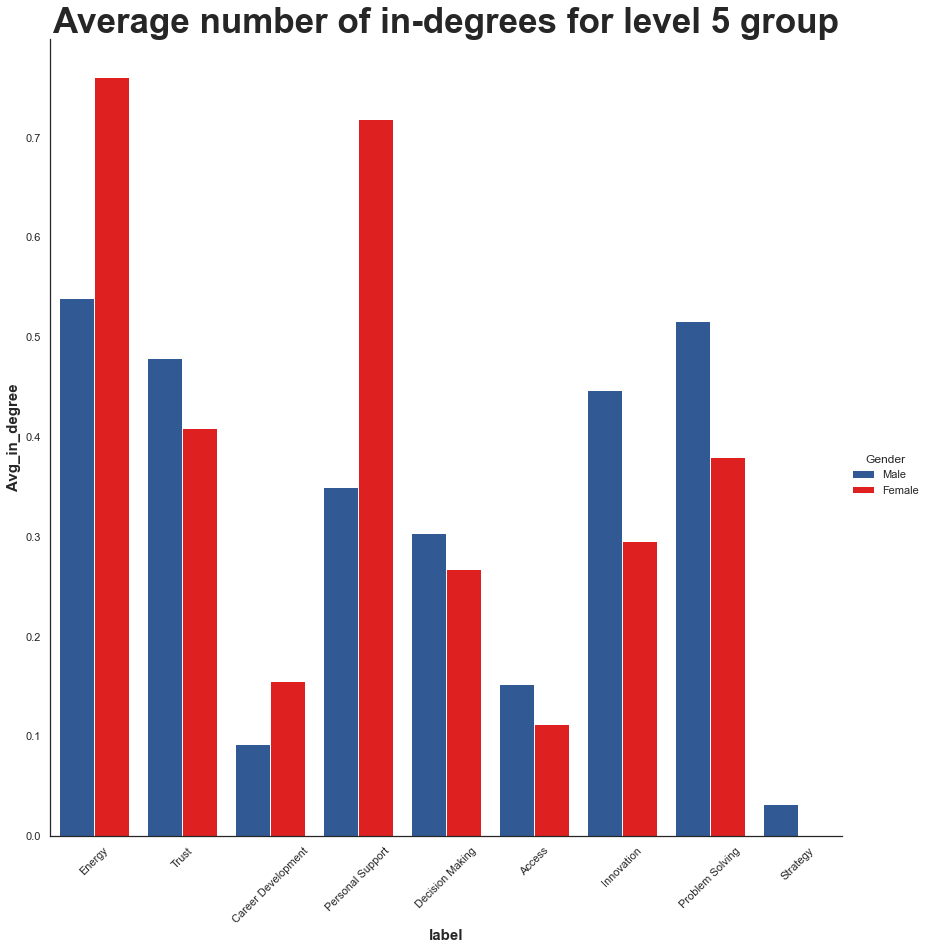

In [688]:
graph_in = sns.catplot(data=new_level5_table1,kind='bar',x='label', y='Avg_in_degree',hue='Gender',height = 11.7,palette = sns.color_palette(['#2157A4','red']))
graph_in.set_xticklabels(rotation = 45)
graph_in.set_xlabels(fontsize=15,fontweight='bold')
graph_in.set_ylabels(fontsize=15,fontweight='bold')
plt.title('Average number of in-degrees for level 5 group',fontsize = 35,fontweight = 'bold')

In [687]:
in_degree_level4_label

,Men,Women,Total
Energy,1.134921,1.365854,1.248996
Trust,1.142857,0.967480,1.056225
Career Development,0.611111,0.495935,0.554217
Personal Support,0.833333,0.943089,0.887550
Decision Making,0.984127,0.878049,0.931727
Access,0.317460,0.211382,0.265060
Innovation,0.968254,0.845528,0.907631
Problem Solving,1.071429,0.991870,1.032129
Strategy,0.555556,0.308943,0.433735


Text(0.5, 1.0, 'Average number of in-degrees for level 4 group')

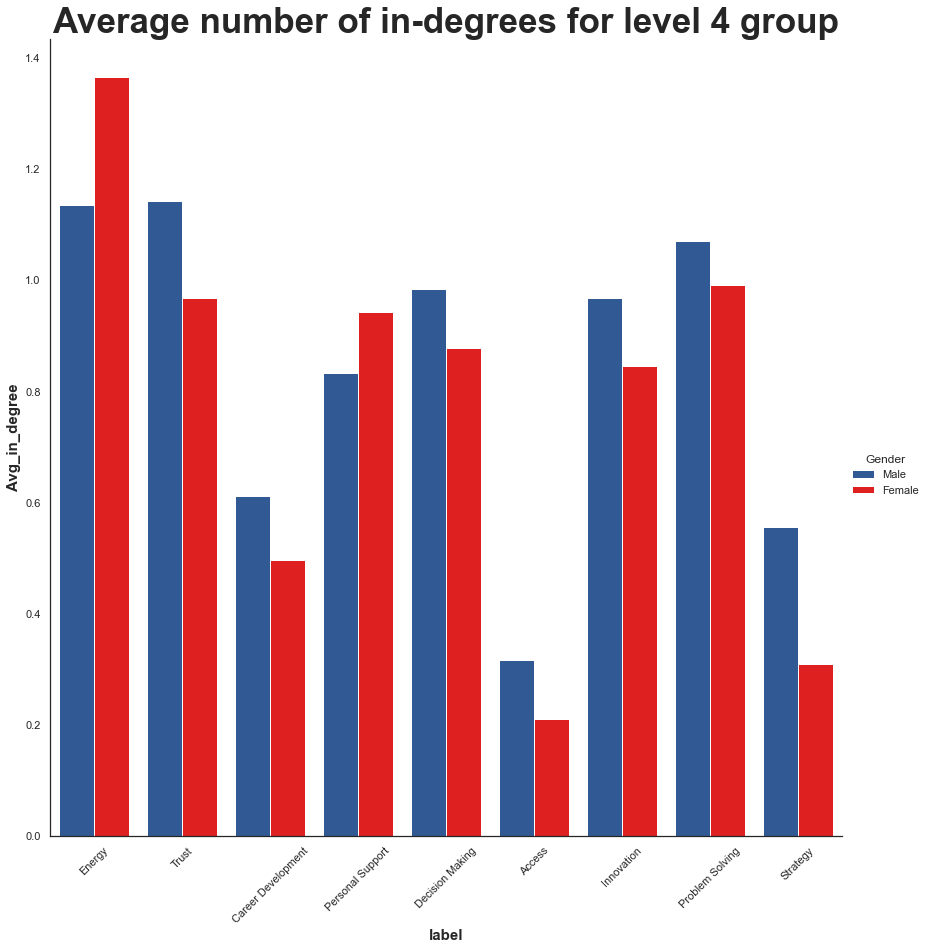

In [689]:
graph_in = sns.catplot(data=new_level4_table1,kind='bar',x='label', y='Avg_in_degree',hue='Gender',height = 11.7,palette = sns.color_palette(['#2157A4','red']))
graph_in.set_xticklabels(rotation = 45)
graph_in.set_xlabels(fontsize=15,fontweight='bold')
graph_in.set_ylabels(fontsize=15,fontweight='bold')
plt.title('Average number of in-degrees for level 4 group',fontsize = 35,fontweight = 'bold')

In [671]:
label_label = []
for label in labels:
    label_label.append(label)

In [672]:
label_label = label_label*3

In [673]:
label_label

['Energy',
 'Trust',
 'Career Development',
 'Personal Support',
 'Decision Making',
 'Access',
 'Innovation',
 'Problem Solving',
 'Strategy',
 'Energy',
 'Trust',
 'Career Development',
 'Personal Support',
 'Decision Making',
 'Access',
 'Innovation',
 'Problem Solving',
 'Strategy',
 'Energy',
 'Trust',
 'Career Development',
 'Personal Support',
 'Decision Making',
 'Access',
 'Innovation',
 'Problem Solving',
 'Strategy']

In [674]:
connection_5 = avg5_in_by_label_male+avg5_in_by_label_female+avg5_in_by_label
connection_4 = avg4_in_by_label_male+avg4_in_by_label_female+avg4_in_by_label

In [675]:
gender = ['Male']*9 +['Female']*9 +['Total']*9

In [676]:
new_level5_table = pd.DataFrame(data = list(zip(label_label,connection_5,gender)),columns=['label','Avg_in_degree','Gender'])
new_level4_table = pd.DataFrame(data = list(zip(label_label,connection_4,gender)),columns=['label','Avg_in_degree','Gender'])

In [677]:
new_level4_table

,label,Avg_in_degree,Gender
0,Energy,1.134921,Male
1,Trust,1.142857,Male
2,Career Development,0.611111,Male
3,Personal Support,0.833333,Male
4,Decision Making,0.984127,Male
5,Access,0.317460,Male
6,Innovation,0.968254,Male
7,Problem Solving,1.071429,Male
8,Strategy,0.555556,Male
9,Energy,1.365854,Female


In [572]:
in_degree_level5_label

,Men,Women,Total
Energy,0.539171,0.760563,0.593750
Trust,0.479263,0.408451,0.461806
Career Development,0.092166,0.154930,0.107639
Personal Support,0.350230,0.718310,0.440972
Decision Making,0.304147,0.267606,0.295139
Access,0.152074,0.112676,0.142361
Innovation,0.447005,0.295775,0.409722
Problem Solving,0.516129,0.380282,0.482639
Strategy,0.032258,0.000000,0.024306


In [573]:
in_degree_level4_label

,Men,Women,Total
Energy,1.134921,1.365854,1.248996
Trust,1.142857,0.967480,1.056225
Career Development,0.611111,0.495935,0.554217
Personal Support,0.833333,0.943089,0.887550
Decision Making,0.984127,0.878049,0.931727
Access,0.317460,0.211382,0.265060
Innovation,0.968254,0.845528,0.907631
Problem Solving,1.071429,0.991870,1.032129
Strategy,0.555556,0.308943,0.433735


In [261]:
n_by_level_in

{'Level 1:[male,female]': (1, 0),
 'Level 2:[male,female]': (7, 2),
 'Level 3:[male,female]': (42, 23),
 'Level 4:[male,female]': (126, 123),
 'Level 5:[male,female]': (217, 71)}